# Predictive Modeling with Random Forest - Dataset 1  

In this section, we extend the modeling of **Dataset 1** by applying a **Random Forest Classifier**.  
The main goals are:  

- Train and evaluate a Random Forest model on the same preprocessed data.  
- Compare its performance against the baseline Logistic Regression.  
- Assess model performance using Accuracy, Precision, Recall, F1-score, Confusion Matrix, and ROC-AUC.  
- Analyze feature importance to understand which variables contribute most to predictions.  
- Establish a foundation for cross-dataset comparison with Dataset 2.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

import joblib

In [2]:
data = pd.read_csv('../data/cleaned_data/dataset1_cleaned.csv')
data

,age,gender,heart_rate,pressure_high,pressure_low,glucose,kcm,troponin,heart_disease
0,64,1,66,160,83,160.0,1.80,0.012,0
1,21,1,94,98,46,296.0,6.75,1.060,1
2,55,1,64,160,77,270.0,1.99,0.003,0
3,64,1,70,120,55,270.0,13.87,0.122,1
4,55,1,64,112,65,300.0,1.08,0.003,0
...,...,...,...,...,...,...,...,...,...
1311,44,1,94,122,67,204.0,1.63,0.006,0
1312,66,1,84,125,55,149.0,1.33,0.172,1
1313,45,1,85,168,104,96.0,1.24,4.250,1
1314,54,1,58,117,68,443.0,5.80,0.359,1


In [3]:
X = data.drop('heart_disease', axis=1)
y = data['heart_disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Classification Report - Random Forest:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       102
           1       0.99      1.00      0.99       162

    accuracy                           0.99       264
   macro avg       0.99      0.99      0.99       264
weighted avg       0.99      0.99      0.99       264



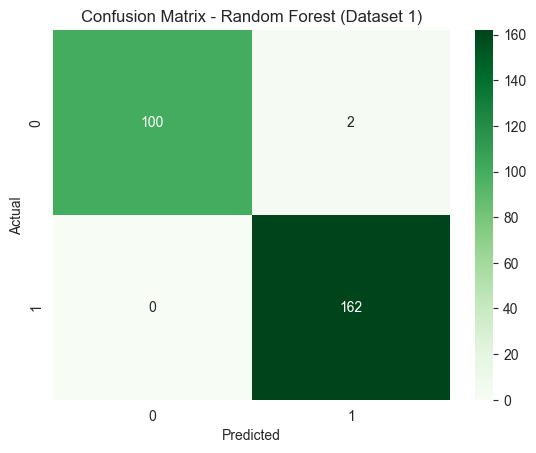

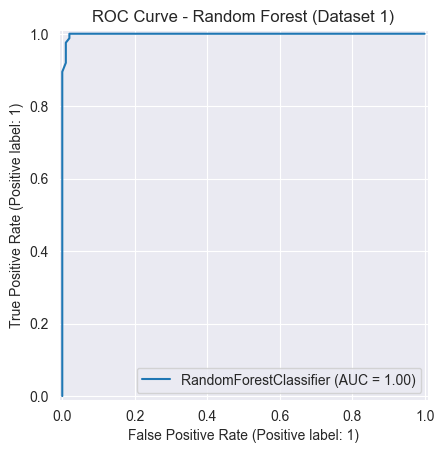

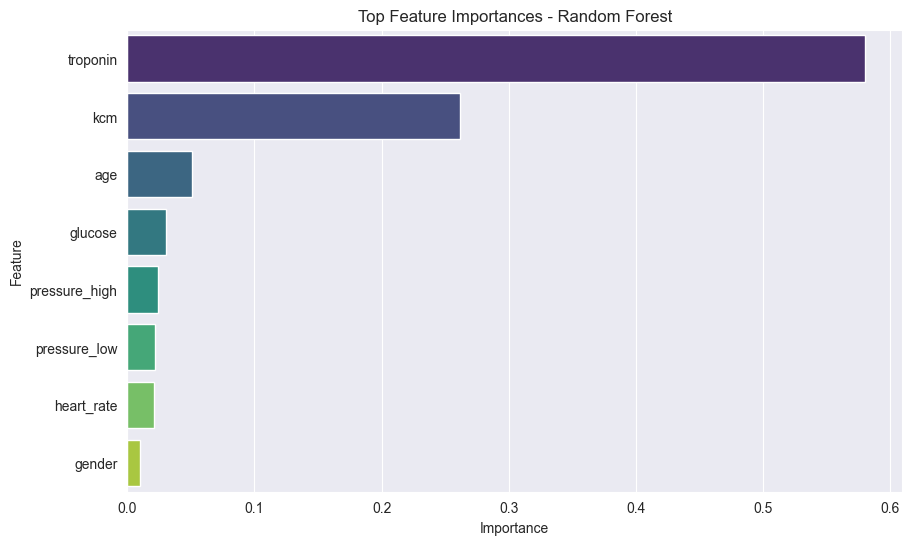

['../models/random_forest_ds1/scaler_ds1.pkl']

In [4]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,       
    random_state=42,
    max_depth=None,         
    class_weight="balanced"
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate performance
print("Classification Report - Random Forest:\n")
print(classification_report(y_test, y_pred_rf))

# report = classification_report(y_test, y_pred_rf, output_dict=True)
# dataset1_report = pd.DataFrame(report).transpose()
# dataset1_report.to_csv("../data/stats_results/random_forest_classification_report_ds1.csv", index=True)

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, 
            annot=True, 
            fmt='d', 
            cmap='Greens', 
            xticklabels=[0,1], 
            yticklabels=[0,1])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest (Dataset 1)")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(rf_model, X_test_scaled, y_test)
plt.title("ROC Curve - Random Forest (Dataset 1)")
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
feat_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))

sns.barplot(
    data=feat_importance.head(15),
    x="Importance",
    y="Feature",
    hue="Feature",        
    dodge=False,
    palette="viridis",
    legend=False
)

plt.title("Top Feature Importances - Random Forest")
plt.show()

# joblib.dump(rf_model, "../models/random_forest_ds1/random_forest_ds1.pkl")
# joblib.dump(scaler, "../models/random_forest_ds1/scaler_ds1.pkl")

## Summary - Random Forest Modeling (Dataset 2)

The Random Forest model achieved **very high predictive performance** on Dataset 2, with an overall accuracy of **99%**.  
Both classes (disease and no disease) were predicted with excellent precision, recall, and F1-scores:

- **Class 0 (No Disease):** Precision = 1.00, Recall = 0.98, F1 = 0.99  
- **Class 1 (Disease):** Precision = 0.99, Recall = 1.00, F1 = 0.99  
- **ROC-AUC = 1.00**, indicating near-perfect separability.

The confusion matrix shows that only **2 misclassifications** occurred out of 264 test samples, which demonstrates the model’s robustness.

### Feature Importances
- The most important feature in the Random Forest model was **Troponin**, followed by **KCM** and **Age**.  
- This is a more clinically consistent result compared to the Logistic Regression model, where **KCM** appeared as the most influential predictor.  
- Troponin, being a well-established biomarker for heart damage, logically dominates the model’s predictive power, which increases confidence in the model’s interpretability.

### Key Takeaways
- Random Forest provides a more reliable and clinically interpretable result compared to Logistic Regression on this dataset.  
- The dominance of **Troponin** as the top predictor highlights its medical relevance and validates the model.  
- The model is highly accurate, but such near-perfect performance could suggest possible **overfitting**, and further validation on external or cross-validation sets may be beneficial.

**In summary:** Random Forest outperforms Logistic Regression on Dataset 2, both in predictive accuracy and in providing feature importances that align better with medical expectations.


## Cross-Validation with Random Forest  

To validate the robustness of our Random Forest model, we perform k-fold cross-validation.  
This method splits the dataset into *k* subsets (folds), trains the model on *k-1* folds,  
and evaluates it on the remaining fold. Repeating this process *k* times provides a more  
reliable estimate of model performance and helps detect potential overfitting.  

In [5]:
rf_model = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))
print("Standard deviation:", np.std(cv_scores))

Cross-validation scores: [0.99621212 0.98098859 0.98098859 0.99239544 0.98479087]
Mean CV accuracy: 0.9870751238621962
Standard deviation: 0.006182231997616848


### Cross-Validation Results (Random Forest – Dataset 1)

To validate the robustness of the model and reduce the risk of overfitting, we applied **Stratified K-Fold Cross-Validation (k=5)**.  

**Results:**
- Cross-validation scores: [0.996, 0.981, 0.981, 0.992, 0.985]  
- **Mean CV accuracy: 0.987**  
- **Standard deviation: 0.006**

### Interpretation
The model shows an exceptionally high mean accuracy (~98.7%) with a very low standard deviation (~0.6%).  
This indicates that the results are stable and consistent across different folds, confirming the reliability of the Random Forest model.  

Compared to Logistic Regression, Random Forest:
- Achieves higher accuracy and stronger generalization.  
- Highlights **Troponin** as the most important predictive feature, which is a more medically consistent finding than Logistic Regression (where KCM appeared as the strongest predictor).  


In [6]:
# data.to_csv("../data/preprocessed_rf/dataset_1_preprocessed.csv", index=False)